In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv("500_Person_Gender_Height_Weight_Index.csv")
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


Imagine that we want to predict whether or not the person is obese. According to the information of the dataset, people with an index of 4 or 5 are obese, so we could create a variable that reflects this:

In [4]:
data['obese'] = (data.Index >= 4).astype('int')
data.drop('Index', axis=1, inplace=True)
data.head()

,Gender,Height,Weight,obese
0,Male,174,96,1
1,Male,189,87,0
2,Female,185,110,1
3,Female,195,104,0
4,Male,149,61,0


We can then define two impurity metric based on Gini index and entropy:

In [5]:
def gini_impurity(y):
    '''
    Given a Pandas Series, it calculates the Gini Impurity.
    y: variable with which calculate Gini Impurity.
    '''
    if isinstance(y, pd.Series):
        a = y.value_counts() / y.shape[0]
        gini = 1 - np.sum(a**2)
        return gini

    else:
        raise ('Object must be a Pandas Series.')


def entropy(y):
    '''
    Given a Pandas Series, it calculates the entropy.
    y: variable with which calculate entropy.
    '''
    if isinstance(y, pd.Series):
        a = y.value_counts() / y.shape[0]
        entropy = np.sum(-a * np.log2(a + 1e-9))
        return (entropy)

    else:
        raise ('Object must be a Pandas Series.')

print(gini_impurity(data.Gender))
print(entropy(data.Gender))

0.4998
0.9997114388674198


In [6]:
#0.4998
#0.9997114388674198

The results above simply implies that 'Gender' can provide almost no information about obesity. This can be described more accurately by measuring information gain (IG), which is defined as follows:
$$
IG=E(d)-\sum _s \frac{|s|}{|d|} E(s)
$$
That is, the information gain is the difference between **overall entropy** and the **weighted sum of the entropy of each cut group**. Implement this function in the following:

In [7]:
def information_gain(y, mask, func=entropy):
    '''
    It returns the Information Gain of a variable given a loss function.
    y: target variable.
    mask: split choice.
    func: function to be used to calculate Information Gain in case os classification.
    '''

    a = sum(mask)
    b = mask.shape[0] - a

    if (a == 0 or b == 0):
        ig = 0
    else:
        pass
        ig = func(y) - (a/mask.shape[0]*func(y[mask]) + b/mask.shape[0]*func(y[~mask]))
    return ig

information_gain(data['obese'], data['Gender'] == 'Male')

0.0005506911187600494

In [8]:
#0.0005506911187600494

Now we can see more clearly that knowing the gender provide little information about obesity. The next question is, how do we select variable for cutting and what is the proper value of cutting? In essence, we achieve this by iterating all possible choices:

In [9]:
def max_information_gain_split(x, y, func=entropy):
    '''
    Given a predictor & target variable, returns the best split, the error and the type of variable based on a selected cost function.
    x: predictor variable as Pandas Series.
    y: target variable as Pandas Series.
    func: function to be used to calculate the best split.
    '''

    split_value = []
    ig = []

    numeric_variable = True if x.dtypes != 'O' else False

    options = x.sort_values().unique()[1:]

    # Calculate ig for all values
    for val in options:
        if numeric_variable==False:
            val_ig = information_gain(y, x==val)
        else:
            val_ig = information_gain(y, x<val)
        ig.append(val_ig)
        split_value.append(val)

    # Check if there are more than 1 results if not, return False
    if len(ig) == 0:
        return (None, None, None, False)

    else:
        # Get results with highest IG
        best_ig = max(ig)
        best_ig_index = ig.index(best_ig)
        best_split = split_value[best_ig_index]
        return (best_ig, best_split, numeric_variable, True)

After having this function, we are able to determine 1) which variable to make a split and 2) how to make the best split:

In [10]:
data.drop('obese', axis=1).apply(max_information_gain_split, y=data['obese'])

,Gender,Height,Weight
0,0.000551,0.064748,0.382454
1,Male,174,103
2,False,True,True
3,True,True,True


The output suggests that we should split by weight first, where the best split can provide us with an information gain of 0.382454.

Next, we are ready to train our decision tree. Several hyperparameters need to be determined to prevent the tree from growing too much, thus avoiding overfitting:

- max_depth: maximum depth of the tree. If we set it to None, the tree will grow until all the leaves are pure or the hyperparameter min_samples_split has been reached.
- min_samples_split: indicates the minimum number of observations a sheet must have to continue creating new nodes.
- min_information_gain: the minimum amount the Information Gain must increase for the tree to continue growing

Then, to create the tree, we need to:

- Make sure that the conditions established by min_samples_split and max_depth are being fulfilled.
- Make the split.
- Ensure that min_information_gain if fulfilled.
- Save the data of the split and repeat the process.

In [11]:
def get_best_split(y, data):
    masks = data.drop(y, axis=1).apply(max_information_gain_split, y=data[y])
    if sum(masks.iloc[3, :]) == 0:
        return (None, None, None, None)

    else:
        # Get only masks that can be splitted
        masks = masks.loc[:, masks.iloc[3, :]]

        # Get the results for split with highest IG
        split_variable = masks.iloc[0].astype(np.float32).idxmax()
        # split_valid = masks[split_variable][]
        split_value = masks[split_variable].iloc[1]
        split_ig = masks[split_variable].iloc[0]
        split_numeric = masks[split_variable].iloc[2]

        return (split_variable, split_value, split_ig, split_numeric)


def make_split(variable, value, data, is_numeric):
    if is_numeric:
        data_1 = data[data[variable] < value]
        data_2 = data[(data[variable] < value) == False]

    else:
        data_1 = data[data[variable].isin(value)]
        data_2 = data[(data[variable].isin(value)) == False]

    return (data_1, data_2)


def make_prediction(data):
    pred = data.value_counts().idxmax()
    return pred


def train_tree(data, y, max_depth=None, min_samples_split=None, min_information_gain=1e-20, counter=0,
               max_categories=20):
    '''
    Trains a Decission Tree
    data: Data to be used to train the Decission Tree
    y: target variable column name
    max_depth: maximum depth to stop splitting.
    min_samples_split: minimum number of observations to make a split.
    min_information_gain: minimum ig gain to consider a split to be valid.
    max_categories: maximum number of different values accepted for categorical values. High number of values will slow down learning process. R
    '''

    # Check that max_categories is fulfilled
    if counter == 0:
        types = data.dtypes
        check_columns = types[types == "object"].index
        for column in check_columns:
            var_length = len(data[column].value_counts())
            if var_length > max_categories:
                raise ValueError('The variable ' + column + ' has ' + str(
                    var_length) + ' unique values, which is more than the accepted ones: ' + str(max_categories))

    # Check for depth conditions
    if max_depth == None:
        depth_cond = True

    else:
        if counter < max_depth:
            depth_cond = True

        else:
            depth_cond = False

    # Check for sample conditions
    if min_samples_split == None:
        sample_cond = True

    else:
        if data.shape[0] > min_samples_split:
            sample_cond = True

        else:
            sample_cond = False

    # Check for ig condition
    if depth_cond & sample_cond:

        var, val, ig, var_type = get_best_split(y, data)

        # If ig condition is fulfilled, make split
        if ig is not None and ig >= min_information_gain:

            counter += 1

            left, right = make_split(var, val, data, var_type)

            # Instantiate sub-tree
            split_type = "<=" if var_type else "in"
            question = "{} {}  {}".format(var, split_type, val)
            # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
            subtree = {question: []}

            # Find answers (recursion)
            yes_answer = train_tree(left, y, max_depth, min_samples_split, min_information_gain, counter)

            no_answer = train_tree(right, y, max_depth, min_samples_split, min_information_gain, counter)

            if yes_answer == no_answer:
                subtree = yes_answer

            else:
                subtree[question].append(yes_answer)
                subtree[question].append(no_answer)

        # If it doesn't match IG condition, make prediction
        else:
            pred = make_prediction(data[y])
            return pred

    # Drop dataset if doesn't match depth or sample conditions
    else:
        pred = make_prediction(data[y])
        return pred

    return subtree

Finally, we can train our tree by setting proper hyperparameters and train it on the training set:

In [12]:
max_depth = 1
min_samples_split = 20
min_information_gain = 1e-5

num_train_data = 400
train_data, val_data = data.iloc[:num_train_data], data.iloc[num_train_data:]

decisions = train_tree(train_data, 'obese', max_depth, min_samples_split, min_information_gain)

The decision tree is:

In [13]:
decisions

{'Weight <=  103': [{'Height <=  178': [{'Weight <=  74': [0,
      {'Height <=  162': [1, {'Weight <=  92': [0, 1]}]}]},
    0]},
  {'Weight <=  116': [{'Height <=  189': [{'Weight <=  115': [1, 0]}, 0]},
    1]}]}

The decision is formatted as a nested container with dict and list. Each decision is a dict with decision as key and a list as value. The list has only two possibilities: another decision or a direct answer (0 or 1, meaning obese or not).
Maybe this description is still obscure, let's classify a real data sample based on our decision rule!

In [14]:
def clasificar_datos(observacion, rule, verbose=False):
    question = list(rule.keys())[0]
    if verbose:
        print(f'determine: {question}')

    if question.split()[1] == '<=':

        if observacion[question.split()[0]] <= float(question.split()[2]):
            if verbose:
                print(f'observation {observacion[question.split()[0]]} less than {float(question.split()[2])}')
            answer = rule[question][0]
        else:
            if verbose:
                print(f'observation {observacion[question.split()[0]]} greater than {float(question.split()[2])}')
            answer = rule[question][1]

    else:

        if observacion[question.split()[0]] in (question.split()[2]):
            answer = rule[question][0]
        else:
            answer = rule[question][1]

    # If the answer is not a dictionary
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return clasificar_datos(observacion, answer, verbose=verbose)


print('decision-tree result:', clasificar_datos(observacion=data.iloc[1], rule=decisions, verbose=True))

determine: Weight <=  103
observation 87 less than 103.0
determine: Height <=  178
observation 189 greater than 178.0
decision-tree result: 0


Therefore, by consecutive decisions, our algorithm finally decides that the sample at index 1 is not obese.
Finally, we can calculate the accuracy of our algorithm as follows:

In [15]:
correct = 0
for i, row in val_data.iterrows():
    if (row.obese and clasificar_datos(row, decisions)) or (not row.obese and not clasificar_datos(row, decisions)):
        correct += 1
print(f'Accuracy of this model is {correct / len(val_data)}')

Accuracy of this model is 0.97


In [18]:
depths = [1, 2, 4, 8, 16]
accu = []
for depth in depths:
    print('Max Tree Depth:', depth)
    max_depth = depth
    min_samples_split = 20
    min_information_gain = 1e-5

    num_train_data = 400
    train_data, val_data = data.iloc[:num_train_data], data.iloc[num_train_data:]

    decisions = train_tree(train_data, 'obese', max_depth, min_samples_split, min_information_gain)
    correct = 0
    for i, row in val_data.iterrows():
        if (row.obese and clasificar_datos(row, decisions)) or (not row.obese and not clasificar_datos(row, decisions)):
            correct += 1
    print(f'Accuracy of this model is {correct / len(val_data)}')
    accu.append(correct / len(val_data))

Max Tree Depth: 1
Accuracy of this model is 0.84
Max Tree Depth: 2
Accuracy of this model is 0.84
Max Tree Depth: 4
Accuracy of this model is 0.94
Max Tree Depth: 8
Accuracy of this model is 0.97
Max Tree Depth: 16
Accuracy of this model is 0.97


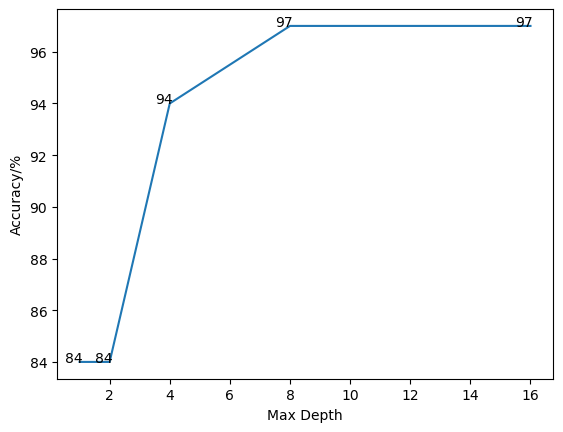

In [35]:
accu = np.array(accu)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(depths, accu*100)
for i,depth in enumerate(depths):
    ax.text(depth-0.5, accu[i]*100, int(accu[i]*100))
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy/%')
plt.savefig('accu.png', dpi=100)
plt.show()